## a.1

In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd

# 读取数据
data_train = pd.read_csv('xy_train.csv',header = None)

# 将数据转换为 numpy 数组
# 使用.values不会返回行列信息，返回numpy数组
X_train = data_train.iloc[:, 0:2].values  # 选择前两列作为特征
y_train = data_train.iloc[:, 2].values    # 第三列作为标签

p = 2  # 特征数量
n = 200  # 样本数量

# 定义 SVM 问题的变量
beta = cp.Variable(p)   # 大小为 (2,) 的向量
beta_0 = cp.Variable()  # 偏置项
xi = cp.Variable(n)     # 松弛变量

# 定义 SVM 问题的约束条件
constraints = [xi >= 0, y_train * (X_train @ beta + beta_0) >= 1 - xi]

# 定义损失函数
C = 1.0  # 正则化超参数
objective = cp.Minimize(0.5 * cp.norm(beta, 2) ** 2 + C * cp.sum(xi))

# 定义问题并求解
problem = cp.Problem(objective, constraints)
problem.solve()

# 输出优化后的结果
print("Optimal beta:", beta.value)
print("Optimal beta_0 (intercept):", beta_0.value)

Optimal beta: [0.00244061 0.00244565]
Optimal beta_0 (intercept): 0.0


/Users/hanhan/anaconda3/envs/Optimization/lib/python3.11/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


## a.2

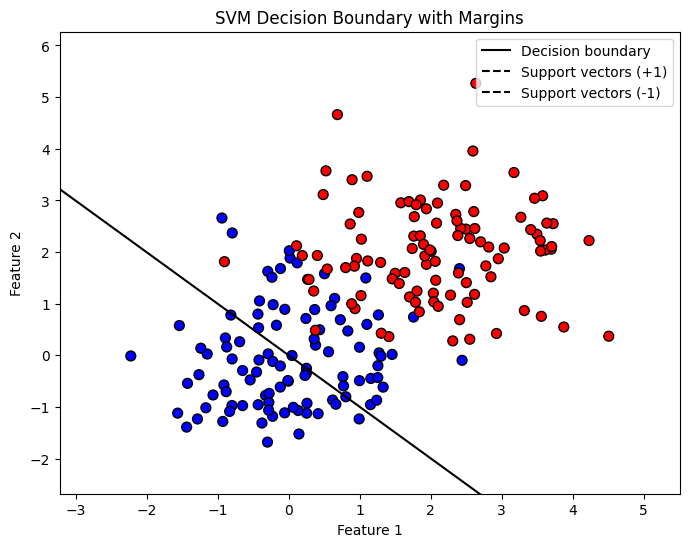

In [27]:
import matplotlib.pyplot as plt
# 画图部分
def plot_svm_boundary(X, y, beta, beta_0):
    plt.figure(figsize=(8, 6))

    # 画出所有的样本点
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=50, edgecolors='k')

    # 计算决策边界
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx = np.linspace(x_min, x_max, 100)

    # 决策边界: beta_0 + beta[0] * x1 + beta[1] * x2 = 0 => x2 = -(beta_0 + beta[0] * x1) / beta[1]
    decision_boundary = -(beta_0 + beta[0] * xx) / beta[1]

    # 支持向量边界: beta_0 + beta[0] * x1 + beta[1] * x2 = ±1
    margin_plus = -(beta_0 + beta[0] * xx - 1) / beta[1]
    margin_minus = -(beta_0 + beta[0] * xx + 1) / beta[1]

    # 画出决策边界
    plt.plot(xx, decision_boundary, 'k-', label="Decision boundary")

    # 画出支持向量的边界
    plt.plot(xx, margin_plus, 'k--', label="Support vectors (+1)")
    plt.plot(xx, margin_minus, 'k--', label="Support vectors (-1)")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title("SVM Decision Boundary with Margins")
    plt.show()

# 调用函数，画出决策边界
plot_svm_boundary(X_train, y_train, beta.value, beta_0.value)

## a.3

In [23]:
# 根据给定的公式，构建 x̃
X_tilde = y_train[:, np.newaxis] * X_train  # x̃ = yixi

# 定义 CVXPY 变量
w = cp.Variable(2)

C1=1

# 目标函数，添加扰动项
objective = cp.Maximize(-0.5 * cp.quad_form(w, X_tilde @ X_tilde.T) + cp.sum(w))

# 约束条件
constraints = [0 <= w, w <= C1, cp.sum(w * y_train.reshape(200,1)) == 0]

# 定义问题并求解
problem = cp.Problem(objective, constraints)
problem.solve()

# 打印结果
w_value = w.value
optimal_value = problem.value
print("最优解 w:", w_value)
print("最优值:", optimal_value)

Exception: Invalid dimensions for arguments.

In [11]:
y_train.shape

(200,)

## a.4

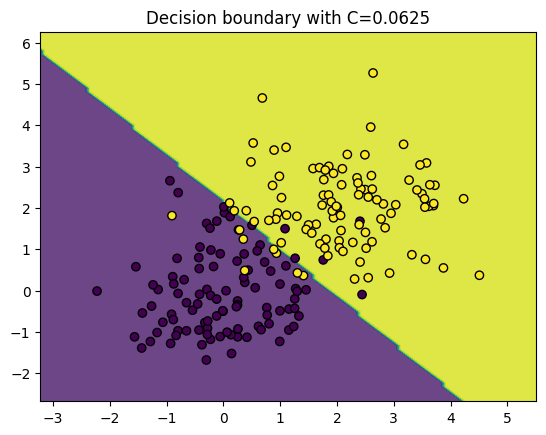

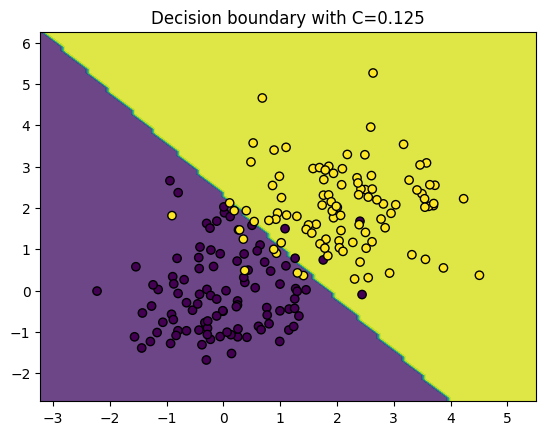

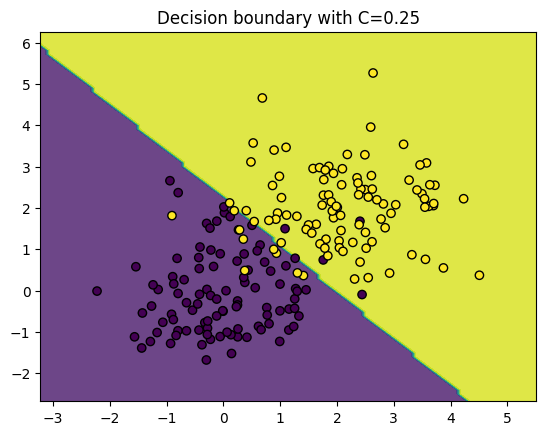

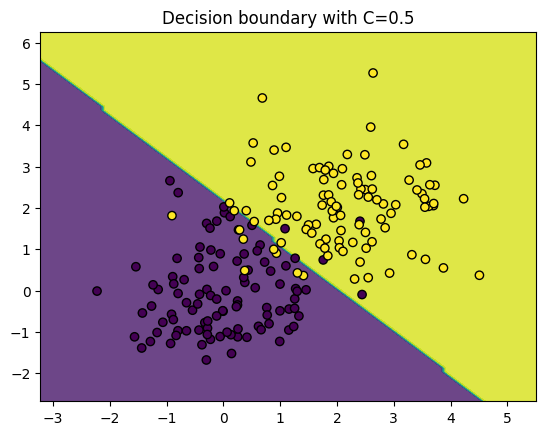

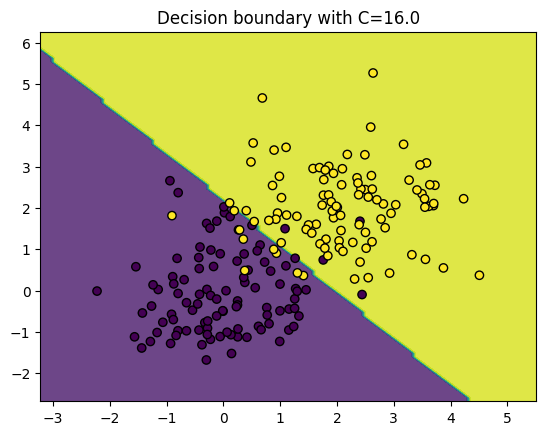

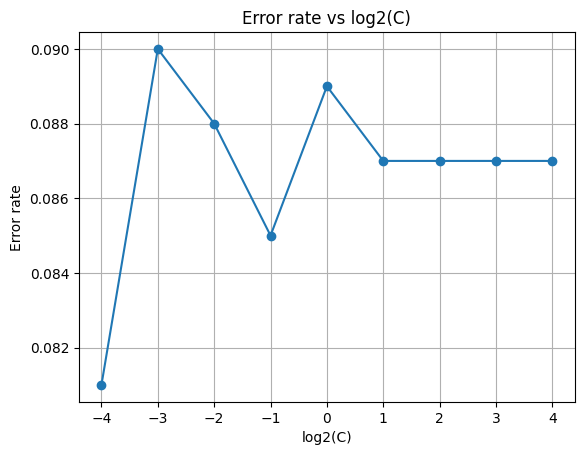

In [31]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

test_data = pd.read_csv('xy_test.csv', header=None)
X_test = test_data.iloc[:, 0:2].values    # 测试集特征
y_test = test_data.iloc[:, 2].values      # 测试集标签
# 定义a的范围 [-4, 4]
a_values = np.arange(-4, 5)
C_values = [2.0**a for a in a_values]  # C = 2^a

# 存储每个C对应的错误率
error_rates = []

def plot_decision_boundary(X, y, beta, beta_0, C):
    """
    该函数用于绘制决策边界
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = np.sign(np.c_[xx.ravel(), yy.ravel()] @ beta + beta_0)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(f'Decision boundary with C={C}')
    plt.show()

# 对每个 C 求解 SVM 问题
for C in C_values:
    # 定义 SVM 的变量
    beta = cp.Variable(p)
    beta_0 = cp.Variable()
    xi = cp.Variable(n)

    # 定义目标函数
    objective = cp.Minimize(0.5 * cp.norm(beta, 2)**2 + C * cp.sum(xi))

    # 定义约束条件
    constraints = [y_train[i] * (X_train[i, :] @ beta + beta_0) >= 1 - xi[i] for i in range(n)]
    constraints += [xi >= 0]  # 松弛变量必须大于等于0

    # 求解问题
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # 使用求得的 beta 和 beta_0 进行预测
    y_pred = np.sign(X_test @ beta.value + beta_0.value)

    # 计算错误率
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

    # 绘制决策边界
    plt.figure()
    plot_decision_boundary(X_train, y_train, beta.value, beta_0.value, C)

# 绘制错误率与 C 的 log-scale 关系图
plt.figure()
plt.plot(a_values, error_rates, marker='o')
plt.xlabel('log2(C)')
plt.ylabel('Error rate')
plt.title('Error rate vs log2(C)')
plt.grid(True)
plt.show()